### SINDy-SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

SINDy-SHRED further extends the SHRED architecture by integrating **Sparse Identification of Nonlinear Dynamics (SINDy)** into the recurrent decoder framework. The key idea is to enforce a **parsimonious latent space representation**, where the dynamics of the latent variables are governed by a **sparse set of basis functions**. 

More formally, SINDy-SHRED introduces an additional inductive bias:

$$\dot{z} = \Theta(z) \xi$$

where:

- $z = \mathcal{G} \left( \{ y_i \} _{i=t-k}^t \right)$ represents the **latent space variables** extracted by the LSTM encoder.
- $\Theta(z)$ is a **library of candidate nonlinear functions**.
- $\xi$ is a **sparse coefficient matrix** that determines the governing equations.

This combination enables **interpretable spatio-temporal modeling** by ensuring that the learned representations adhere to a **governing law**, making the method suitable for **data-driven discovery of dynamical systems** from high-dimensional, noisy observations.

In this notebook, we will walk through the application of **SINDy-SHRED** on the **weekly mean sea-surface temperature (SST) dataset**, demonstrating how the model can **learn a reduced-order latent representation** and **recover the governing equations** that describe the SST evolution.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [2]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset

import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import sindy

num_sensors = 250
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

(1400, 64800)


##### Specify your device here

In [3]:
# Set as CPU (default)
device = 'cpu'

# Automatically select GPU if available
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Change to GPU with device ID
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

We now select indices to divide the data into training, validation, and test sets.

Set random seed

In [4]:
import random
import numpy as np
import torch
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [5]:
train_indices = np.arange(0,1000)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[:30]
test_indices = valid_test_indices[30:]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [6]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [7]:
len(test_dataset)

318

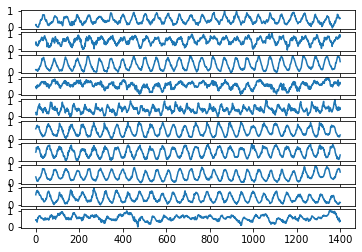

In [9]:
sub_index_X = transformed_X[:,sensor_locations]
fig, ax = plt.subplots(min(num_sensors,10))

for i in range(min(num_sensors,10)):
    ax[i].plot(sub_index_X[:,i])

We set up SINDy library coefficients

In [10]:
latent_dim = 3
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)

We train the model using the training and validation datasets.

In [11]:
import sindy_shred
import importlib
importlib.reload(sindy_shred)
importlib.reload(sindy)
shred = sindy_shred.SINDy_SHRED(num_sensors, m, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1, 
                                 library_dim=library_dim, poly_order=poly_order, include_sine=include_sine, dt=1/52.0*0.1, layer_norm=False, device=device).to(device)
validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200, lr=1e-3, verbose=True, threshold=0.05, patience=5, sindy_regularization=10.0, optimizer="AdamW", thres_epoch=100)

1 : tensor(0.0847, grad_fn=<AddBackward0>)
2 : tensor(0.0684, grad_fn=<AddBackward0>)
3 : tensor(0.0594, grad_fn=<AddBackward0>)
4 : tensor(0.0530, grad_fn=<AddBackward0>)
5 : tensor(0.0524, grad_fn=<AddBackward0>)
6 : tensor(0.0509, grad_fn=<AddBackward0>)
7 : tensor(0.0487, grad_fn=<AddBackward0>)
8 : tensor(0.0429, grad_fn=<AddBackward0>)
9 : tensor(0.0297, grad_fn=<AddBackward0>)
10 : tensor(0.0284, grad_fn=<AddBackward0>)
11 : tensor(0.0245, grad_fn=<AddBackward0>)
12 : tensor(0.0235, grad_fn=<AddBackward0>)
13 : tensor(0.0237, grad_fn=<AddBackward0>)
14 : tensor(0.0226, grad_fn=<AddBackward0>)
15 : tensor(0.0219, grad_fn=<AddBackward0>)
16 : tensor(0.0216, grad_fn=<AddBackward0>)
17 : tensor(0.0209, grad_fn=<AddBackward0>)
18 : tensor(0.0208, grad_fn=<AddBackward0>)
19 : tensor(0.0209, grad_fn=<AddBackward0>)
20 : tensor(0.0204, grad_fn=<AddBackward0>)
21 : tensor(0.0209, grad_fn=<AddBackward0>)
22 : tensor(0.0201, grad_fn=<AddBackward0>)
23 : tensor(0.0202, grad_fn=<AddBackward0

In [12]:
# Rate of sparsity
torch.mean(shred.e_sindy.coefficient_mask*1.0)

tensor(0.8500)

We then generate reconstructions from the test set and print mean square error compared to the ground truth.

In [13]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.053377677


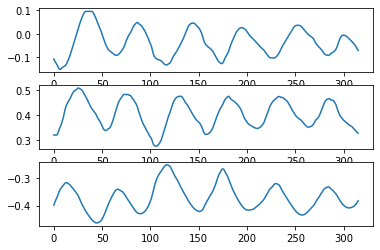

In [14]:
import pysindy as ps
from pysindy.differentiation import FiniteDifference
gru_outs, sindy_outs = shred.gru_outputs(test_dataset.X, sindy=True)
differentiation_method = FiniteDifference()

fig, ax = plt.subplots(latent_dim)
for i in range(latent_dim):
    ax[i].plot(gru_outs[1:,0,i].detach().cpu().numpy())

### Model discovery with SINDy

The following code block extracts latent states using a GRU model. Each of the first three dimensions is normalized and re-scaled to [-1,1]. A SINDy model is then set up with a polynomial library. This SINDy model is fitted to the data and later used to simulate the dynamics for comparison with the original GRU latent trajectories.

The hyperparameters for the SINDy model are set as follows:
- **Differentiation Method:** Finite difference is used to compute numerical derivatives. When the latent states trajectories are noisy, one should consider to use ps.differentiation.SmoothedFiniteDifference().
- **Optimizer Sequantially thresholded least-squares: STLSQ:**  
  - *Threshold:* 0.8, which controls the sparsity level by eliminating coefficients below this value.
  - *Alpha:* 0.05, L2 regularization.
- **Optimizer Mixed-interger optimization: MIOSR:**  
  - *group_sparsity:* how many termseach equations should include. 
- **Feature Library:** Here we only include polynomial features up to degree 1, ensuring only linear terms are considered in the model. Practically this could set up to degree 3 which will include more nonlinear terms. 

For model selection, a simple baseline standard is to visually examine how the long-term extrapolation behaves. We can pick the model that fits the data well. It is also possible to include metrics (like the MSE) to quantitatively measure these quantities. 

(x0)' = 0.355 1 + 2.026 x0 + 4.028 x1 + 3.035 x2
(x1)' = 0.726 1 + -1.283 x0 + -0.531 x1 + 5.717 x2
(x2)' = -0.155 1 + -2.831 x0 + -4.758 x1 + -1.547 x2


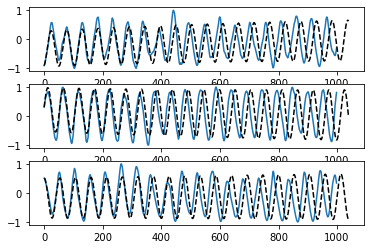

In [15]:
gru_outs, sindy_outs = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs = gru_outs[:,0,:]

poly_order = 1
threshold = 0.05

###############Normalization###############

gru_outs[:,0] = (gru_outs[:,0] - torch.min(gru_outs[:,0])) / (torch.max(gru_outs[:,0])-torch.min(gru_outs[:,0]))
gru_outs[:,1] = (gru_outs[:,1] - torch.min(gru_outs[:,1])) / (torch.max(gru_outs[:,1])-torch.min(gru_outs[:,1]))
gru_outs[:,2] = (gru_outs[:,2] - torch.min(gru_outs[:,2])) / (torch.max(gru_outs[:,2])-torch.min(gru_outs[:,2]))

gru_outs = 2 * gru_outs - 1

###############SINDy discovery###############

x = gru_outs.detach().cpu().numpy()

differentiation_method = ps.differentiation.FiniteDifference()
# differentiation_method = ps.differentiation.SmoothedFiniteDifference()

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.0, alpha=0.05),
    differentiation_method=differentiation_method,
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)

# model = ps.SINDy(
#     optimizer=ps.MIOSR(group_sparsity=(2,2,2), alpha=5000),
#     differentiation_method=differentiation_method,
#     feature_library=ps.PolynomialLibrary(degree=poly_order),
# )

model.fit(x, t=1/52.0, ensemble=False)
model.print()


###############Plot the discovered SINDy model###############

t_train = np.arange(0, 20, 1/52.0)
init_cond = np.zeros(latent_dim)
init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
x_sim = model.simulate(init_cond, t_train)

fig, ax = plt.subplots(latent_dim)
for i in range(latent_dim):
    ax[i].plot(gru_outs[:,i].detach().cpu().numpy())
    ax[i].plot(x_sim[:,i], "k--", label="model")

##### Reload data from the entire training set

In [16]:
gru_outs_train, _ = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs_train = gru_outs_train[:,0,:]
gru_outs_val, _ = shred.gru_outputs(valid_dataset.X, sindy=True)
gru_outs_val = gru_outs_val[:,0,:]
gru_outs_test, _ = shred.gru_outputs(test_dataset.X, sindy=True)
gru_outs_test = gru_outs_test[:,0,:]

In [17]:
gru_outs_all = np.zeros((1345, 3))
gru_outs_all[:999,:] = gru_outs_train.detach().cpu().numpy()
gru_outs_all[999:1028,:] = gru_outs_val.detach().cpu().numpy()
gru_outs_all[1028:,:] = gru_outs_test.detach().cpu().numpy()

gru_outs_numpy = gru_outs_train.detach().cpu().numpy()

gru_outs_all[:,0] = (gru_outs_all[:,0] - np.min(gru_outs_numpy[:,0])) / (np.max(gru_outs_numpy[:,0])-np.min(gru_outs_numpy[:,0]))
gru_outs_all[:,1] = (gru_outs_all[:,1] - np.min(gru_outs_numpy[:,1])) / (np.max(gru_outs_numpy[:,1])-np.min(gru_outs_numpy[:,1]))
gru_outs_all[:,2] = (gru_outs_all[:,2] - np.min(gru_outs_numpy[:,2])) / (np.max(gru_outs_numpy[:,2])-np.min(gru_outs_numpy[:,2]))

gru_outs_all = 2 * gru_outs_all - 1

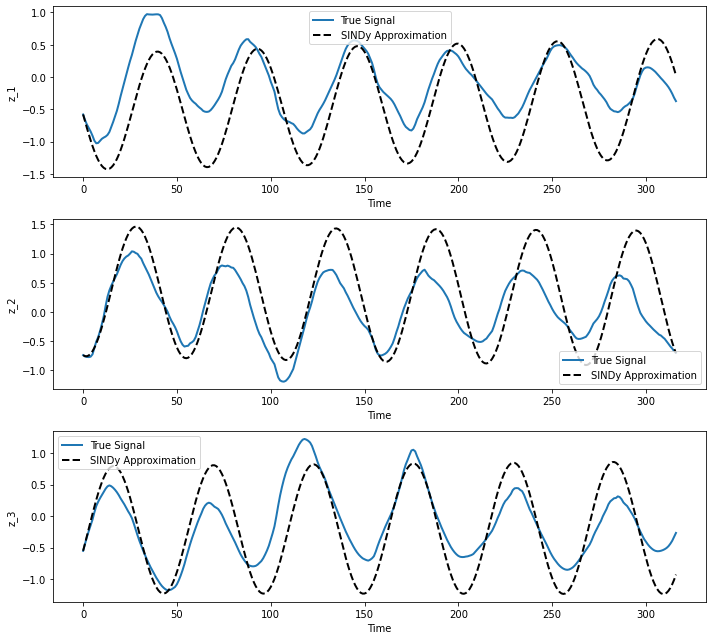

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat

###############Normalization###############
gru_outs_test_np = gru_outs_test.detach().cpu().numpy()

gru_outs_test_np[:, 0] = (gru_outs_test_np[:, 0] - np.min(gru_outs_numpy[:, 0])) / (np.max(gru_outs_numpy[:, 0]) - np.min(gru_outs_numpy[:, 0]))
gru_outs_test_np[:, 1] = (gru_outs_test_np[:, 1] - np.min(gru_outs_numpy[:, 1])) / (np.max(gru_outs_numpy[:, 1]) - np.min(gru_outs_numpy[:, 1]))
gru_outs_test_np[:, 2] = (gru_outs_test_np[:, 2] - np.min(gru_outs_numpy[:, 2])) / (np.max(gru_outs_numpy[:, 2]) - np.min(gru_outs_numpy[:, 2]))

gru_outs_test_np = 2 * gru_outs_test_np - 1  # Transform to [-1, 1]

################Forward simulation with the model################
t_train = np.arange(0, 317*1/52.0, 1/52.0)
init_cond = np.zeros(latent_dim)
init_cond[:latent_dim] = gru_outs_test_np[0, :]
x_sim_test = model.simulate(init_cond, t_train)

# Plotting for each latent dimension: True vs SINDy
fig, ax = plt.subplots(latent_dim, figsize=(10, latent_dim * 3))

for i in range(latent_dim):
    ax[i].plot(gru_outs_test_np[:, i], label='True Signal', linewidth=2)
    ax[i].plot(x_sim_test[:, i], "k--", label='SINDy Approximation', linewidth=2)
    ax[i].legend()
    ax[i].set_ylabel(f'z_{i+1}')
    ax[i].set_xlabel('Time')

plt.tight_layout()
plt.show()

###############Predict back in the pixel space###############

# Step 1: Revert the normalization to original scale
gru_outs_test_np = (gru_outs_test_np + 1) / 2  # Revert from [-1, 1] to [0, 1]

for i in range(3):  # Assuming 3 latent dimensions for this example
    gru_outs_test_np[:, i] = gru_outs_test_np[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

# Step 2: Decoder reconstruction using the decoder model
latent_pred = torch.FloatTensor(gru_outs_test_np).to(device)

# Pass through the decoder
output = shred.linear1(latent_pred)
output = shred.dropout(output)
output = torch.nn.functional.relu(output)
output = shred.linear2(output)
output = shred.dropout(output)
output = torch.nn.functional.relu(output)
output = shred.linear3(output)

output_np = output.detach().cpu().numpy()

In [19]:
###############Plotting settings###############
load_X = loadmat('Data/SST_data.mat')['Z'].T
mean_X = np.mean(load_X, axis=0)
sst_locs = np.where(mean_X != 0)[0]
reconstructed_data = np.zeros_like(load_X[0, :])
reconstructed_data[sst_locs] = output_np[0, :]  # Assuming first timestep
reshaped_reconstructed = reconstructed_data.reshape(180, 360)

34.969986


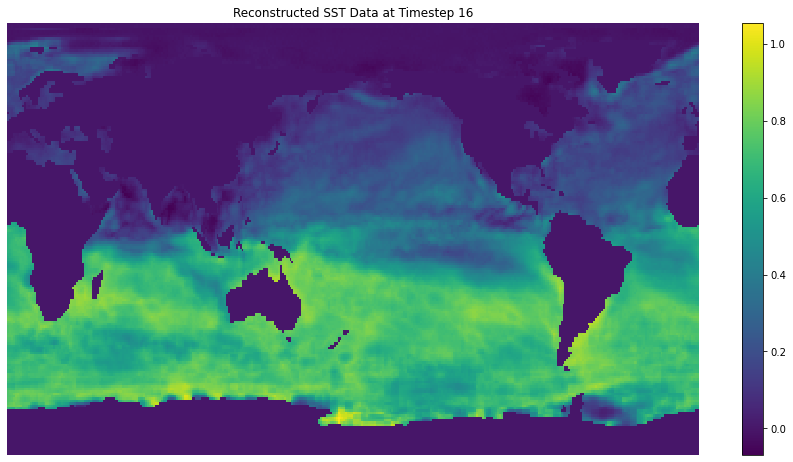

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat

def reconstruct_and_plot_sindy(x_sim_test, gru_outs_numpy, decoder_model, sst_data_path, timesteps):
    """
    Reconstructs and visualizes data using SINDy-simulated latent space for multiple timesteps.
    
    Args:
        x_sim_test (np.array): SINDy-simulated latent space.
        gru_outs_numpy (np.array): The original latent space for Min-Max scaling reversal.
        decoder_model (nn.Module): The decoder model for reconstruction.
        sst_data_path (str): Path to the SST data file.
        timesteps (list of int): List of timesteps to plot.

    Returns:
        None. It generates and shows the plots.
    """
    # Step 1: Reverse Min-Max scaling for SINDy-simulated data (x_sim_test)
    x_sim_test = np.array(x_sim_test)  # Ensure it's a numpy array if needed

    # Revert the scaling from [-1, 1] back to [0, 1]
    x_sim_test = (x_sim_test + 1) / 2  

    # Perform the Min-Max reverse transformation using the original min/max values
    for i in range(3):  # Assuming 3 latent dimensions, need to be updated
        x_sim_test[:, i] = x_sim_test[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

    # Perform the decoder reconstruction using the transformed SINDy-simulated data
    latent_pred_sindy = torch.FloatTensor(x_sim_test).to(device)  # Convert to torch tensor for reconstruction

    # Pass the SINDy-simulated latent space data through the decoder
    output_sindy = decoder_model.linear1(latent_pred_sindy)
    output_sindy = decoder_model.dropout(output_sindy)
    output_sindy = torch.nn.functional.relu(output_sindy)
    output_sindy = decoder_model.linear2(output_sindy)
    output_sindy = decoder_model.dropout(output_sindy)
    output_sindy = torch.nn.functional.relu(output_sindy)
    output_sindy = decoder_model.linear3(output_sindy)

    # Detach and convert the reconstructed data back to numpy for visualization
    output_sindy_np = output_sindy.detach().cpu().numpy()
    load_X = loadmat(sst_data_path)['Z'].T
    mean_X = np.mean(load_X, axis=0)
    sst_locs = np.where(mean_X != 0)[0]

    # Prepare the SST data reconstruction and plot for each timestep
    for t in timesteps:
        # Initialize an empty array with the same shape as the original SST data
        reconstructed_data_sindy = np.zeros_like(load_X[0, :])

        # Copy the SINDy-reconstructed values back to the SST locations for the current timestep
        reconstructed_data_sindy[sst_locs] = output_sindy_np[t, :]  # Use the selected timestep
        print(np.sum(np.square(output_sindy_np[t,:]-output_sindy_np[t+1, :])))

        # Reshape the SST data back to its original 2D form (180, 360)
        reshaped_reconstructed_sindy = reconstructed_data_sindy.reshape(180, 360)

        # Step 5: Visualization of the SST data reconstructed using the SINDy-simulated latent space
        plt.figure(figsize=(12, 6))
        plt.imshow(reshaped_reconstructed_sindy, aspect='auto', interpolation='nearest')
        plt.colorbar()  # Add a color bar to show the value range

        # Remove axes, ticks, and background for a clean image
        plt.gca().set_axis_off()

        # Show the plot with transparent background
        plt.tight_layout(pad=0)
        plt.title(f'Reconstructed SST Data at Timestep {t}')
        plt.show()
    return output_sindy_np

# Example usage
# Assuming decoder_model is your decoder, and timesteps are [0, 10, 50] or any set of timesteps you'd like to plot
timesteps = [16]  # Define timesteps to plot
output_sindy_np = reconstruct_and_plot_sindy(x_sim_test, gru_outs_numpy, shred, 'Data/SST_data.mat', timesteps)


### Comparing the true data to predictions

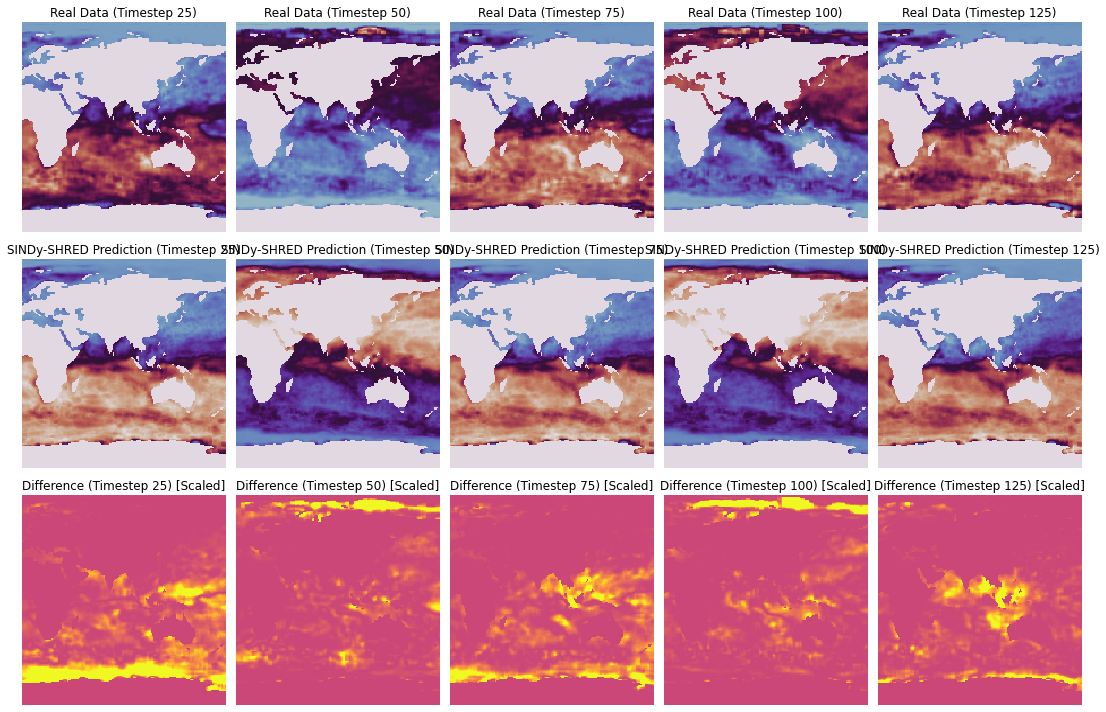

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_zoomed_comparison(real_data, sindy_data, sst_locs, timesteps, lat_range, lon_range, diff_scale=10):
    """
    Plot the real SST data, SINDy-SHRED predictions, and their differences in a specific area (zoomed).
    The difference is amplified by a scaling factor to make it clearer.

    Args:
        real_data (np.array): The ground truth SST data.
        sindy_data (np.array): The SINDy-SHRED reconstructed data.
        sst_locs (np.array): Indices of non-zero SST locations.
        timesteps (list of int): List of timesteps to visualize.
        lat_range (tuple): Latitude range for zoom (e.g., (start_lat, end_lat)).
        lon_range (tuple): Longitude range for zoom (e.g., (start_lon, end_lon)).
        diff_scale (float): Scaling factor for amplifying the difference plot.

    Returns:
        None. Displays the comparison plots.
    """
    num_plots = len(timesteps)
    
    fig, axes = plt.subplots(3, num_plots, figsize=(15, 10))
    
    real_data_inverse_transformed = sc.inverse_transform(real_data)
    sindy_data_inverse_transformed = sc.inverse_transform(sindy_data)
    for i, t in enumerate(timesteps):
        # Plot Real Data
        real_sst = np.zeros((180 * 360))-0.25
        real_sst[sst_locs] = 1*(real_data[t, :])
        reshaped_real_sst = real_sst.reshape(180, 360)
        
        # Select the region of interest (lat_range, lon_range)
        real_sst_zoomed = reshaped_real_sst[lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]]
        axes[0, i].imshow(real_sst_zoomed, aspect='auto', cmap='twilight', interpolation='none')
        axes[0, i].set_title(f'Real Data (Timestep {t})')
        axes[0, i].set_axis_off()

        # Plot SINDy-SHRED Prediction
        sindy_sst = np.zeros((180 * 360))-0.25
        sindy_sst[sst_locs] = 1*(sindy_data[t, :])
        reshaped_sindy_sst = sindy_sst.reshape(180, 360)
        
        # Select the region of interest (lat_range, lon_range)
        sindy_sst_zoomed = reshaped_sindy_sst[lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]]
        axes[1, i].imshow(sindy_sst_zoomed, aspect='auto', cmap='twilight', interpolation='none')
        axes[1, i].set_title(f'SINDy-SHRED Prediction (Timestep {t})')
        axes[1, i].set_axis_off()

        # Plot Difference (Real - SINDy) with scaling factor
        diff_sst_zoomed = 10*np.square(real_sst_zoomed - sindy_sst_zoomed)
        axes[2, i].imshow(diff_sst_zoomed, aspect='auto', cmap='plasma', interpolation='none', vmin=-1, vmax=1)  # Blue-White-Red for differences
        axes[2, i].set_title(f'Difference (Timestep {t}) [Scaled]')
        axes[2, i].set_axis_off()
        
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
timesteps = [25, 50, 75, 100, 125]  # Define the timesteps you want to compare
lat_range = (0, 180)  # Define the latitude range to zoom in (adjust based on your grid)
lon_range = (0, 180)  # Define the longitude range to zoom in (adjust based on your grid)
plot_zoomed_comparison(test_dataset.Y.detach().cpu().numpy(), output_sindy_np, sst_locs, timesteps, lat_range, lon_range, diff_scale=10)


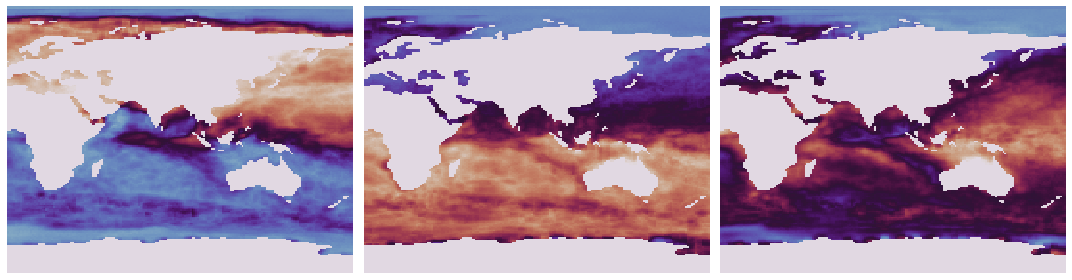

In [22]:
def plot_rescaled_latent_reconstructions(decoder_model, sst_data_path, gru_outs_numpy):
    """
    Rescales and plots the decoder reconstruction for specific latent space vectors (1,0,0), (0,1,0), and (0,0,1).
    Keeps consistent numerical scales and visualization styles.

    Args:
        decoder_model (nn.Module): The decoder model for reconstruction.
        sst_data_path (str): Path to the SST data file.
        gru_outs_numpy (np.array): Original latent space data for Min-Max scaling reversal.

    Returns:
        None. Displays the plots.
    """
    # Define the specific latent space vectors
    latent_vectors = np.eye(3)  # (1,0,0), (0,1,0), (0,0,1)
    # Convert latent vectors to a torch tensor
    latent_vectors_tensor = torch.FloatTensor(latent_vectors).to(device)
    
    for i in range(3):  # Assuming 3 latent dimensions
        latent_vectors_tensor[:, i] = latent_vectors_tensor[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

    # Perform reconstruction using the decoder
    output_reconstructed = decoder_model.linear1(latent_vectors_tensor)
    output_reconstructed = decoder_model.dropout(output_reconstructed)
    output_reconstructed = torch.nn.functional.relu(output_reconstructed)
    output_reconstructed = decoder_model.linear2(output_reconstructed)
    output_reconstructed = decoder_model.dropout(output_reconstructed)
    output_reconstructed = torch.nn.functional.relu(output_reconstructed)
    output_reconstructed = decoder_model.linear3(output_reconstructed)

    # Convert reconstructed data back to numpy
    output_reconstructed_np = output_reconstructed.detach().cpu().numpy()
    
    # Load the SST data to determine grid locations
    load_X = loadmat(sst_data_path)['Z'].T
    mean_X = np.mean(load_X, axis=0)
    sst_locs = np.where(mean_X != 0)[0]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Plot each reconstructed result
    for i, vec in enumerate(latent_vectors):
        # Initialize an empty array for the entire SST grid
        reconstructed_sst = np.zeros_like(load_X[0, :]) - 0.25

        # Fill the SST grid with the reconstructed values
        reconstructed_sst[sst_locs] = output_reconstructed_np[i, :]

        # Reshape the SST data to 2D (180, 360)
        reshaped_sst = reconstructed_sst.reshape(180, 360)
        
        reshaped_sst = reshaped_sst[lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]]
        axes[i].imshow(reshaped_sst, aspect='auto', cmap='twilight', interpolation='none')
        axes[i].set_axis_off()

    plt.tight_layout()
    plt.show()

plot_rescaled_latent_reconstructions(
    decoder_model=shred,
    sst_data_path='Data/SST_data.mat',
    gru_outs_numpy=gru_outs_numpy
)


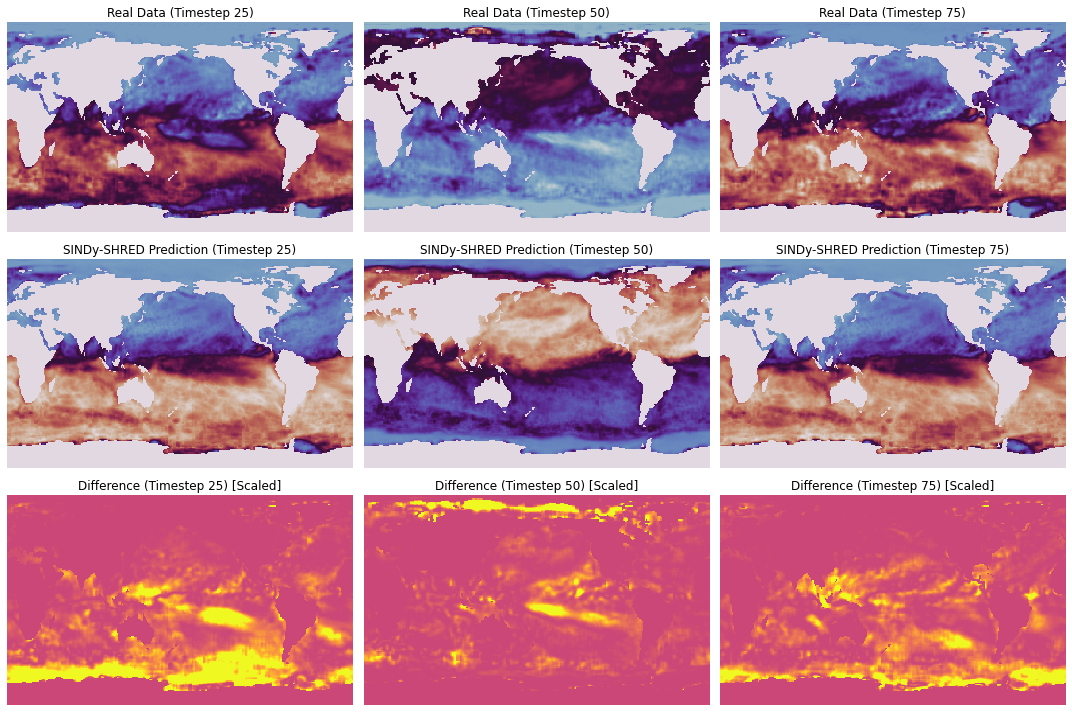

In [23]:
# Example usage:
timesteps = [25, 50, 75]  # Define the timesteps you want to compare
lat_range = (0, 180)  # Define the latitude range to zoom in (adjust based on your grid)
lon_range = (0, 360)  # Define the longitude range to zoom in (adjust based on your grid)
plot_zoomed_comparison(test_dataset.Y.detach().cpu().numpy(), output_sindy_np, sst_locs, timesteps, lat_range, lon_range, diff_scale=10)

### Sensor-level plots

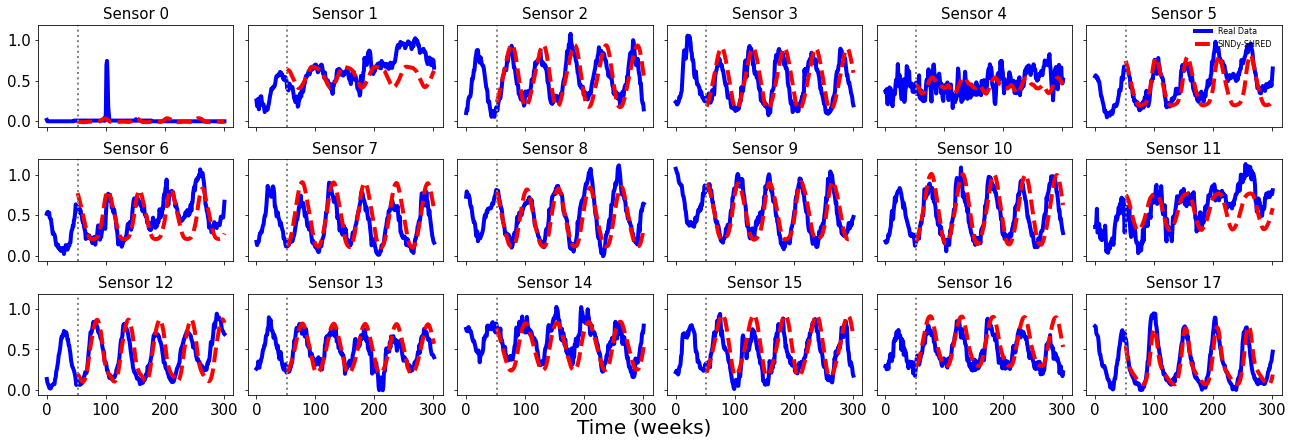

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_sensor_predictions(real_data, sindy_data, sensor_locations, sensor_indices, num_train=52, num_pred=250, rows=4, cols=4):
    """
    Plot the real data and SINDy-SHRED prediction for multiple sensors in a grid layout.
    
    Args:
        real_data (np.array): The real SST data.
        sindy_data (np.array): The predicted data from SINDy-SHRED.
        sensor_locations (np.array): Sensor locations (indices) used in training.
        sensor_indices (list): Indices of the sensors to visualize.
        num_train (int): Number of training data points (default is 100).
        num_pred (int): Number of prediction data points (default is 100).
        rows (int): Number of rows in the grid layout.
        cols (int): Number of columns in the grid layout.
    
    Returns:
        None. Displays and saves the plot.
    """
    num_sensors = len(sensor_indices)
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 2*rows), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing
    
    for i, sensor_idx in enumerate(sensor_indices):
        if i >= rows * cols:
            break  # Stop if we've exceeded the number of subplots
        
        sensor = sensor_locations[sensor_idx]
        
        # Real data for the training period
        sensor_real_data = real_data[:num_train+num_pred, sensor]
        
        # SINDy-SHRED prediction for the prediction period
        sensor_pred_data = sindy_data[num_train:num_train+num_pred, sensor]
        
        axes[i].plot(np.arange(num_train+num_pred), sensor_real_data, color="blue", linewidth=4)
        axes[i].plot(np.arange(num_train, num_train+num_pred), sensor_pred_data, color="red", linestyle="--", linewidth=4)
        
        axes[i].set_title(f'Sensor {sensor_idx}', fontsize=15)
        axes[i].tick_params(axis='both', which='major', labelsize=15)
        
        # Add a vertical line to separate training and prediction periods
        axes[i].axvline(x=num_train, color='gray', linestyle=':', linewidth=2)
        
    # Remove any unused subplots
    for i in range(num_sensors, rows * cols):
        fig.delaxes(axes[i])
    
    # Add labels and title
    fig.text(0.5, 0.0, 'Time (weeks)', ha='center', va='center', fontsize=20)
#     fig.text(0.02, 0.5, 'Sensor Value', ha='center', va='center', rotation='vertical', fontsize=10)
#     fig.suptitle("Real Data (blue) vs SINDy-SHRED Prediction (red dashed)", fontsize=14)
    
    # Add a common legend
    lines = [plt.Line2D([0], [0], color="blue", lw=4),
             plt.Line2D([0], [0], color="red", linestyle="--", lw=4)]
    labels = ["Real Data", "SINDy-SHRED"]
    fig.legend(lines, labels, loc="upper right", bbox_to_anchor=(0.99, 0.945), fontsize=8, frameon=False)
    
    plt.tight_layout()
    plt.savefig('sensor_predictions_grid.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Example usage:
sensor_locations_test = np.random.randint(1, 40000, size=18)
sensor_indices = list(range(0, 18, 1))  # Choose 32 sensors (0, 5, 10, ..., 155)
plot_multiple_sensor_predictions(test_dataset.Y.detach().cpu().numpy(), output_sindy_np, sensor_locations_test, sensor_indices, rows=3, cols=6)